## nSBM for random network

In this notebook we show how nSBM performs when random data are presented. In particular, we analyze PBMC data (preprocessed by scanpy) and randomize the kNN graph.

In [1]:
import scanpy as sc
import schist as scs
import scipy.sparse
import warnings
import powerlaw
import scipy.stats
import graph_tool.all as gt
warnings.filterwarnings("ignore")
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.settings.verbosity = 2
sc.set_figure_params(dpi_save=300)

In [3]:
adata = sc.datasets.pbmc3k_processed()
rdata = adata.copy()

In [4]:
adata.uns['neighbors']['params']['method'] = 'umap'
adata.uns['neighbors']['params']['n_neighbos'] = n_neighbors


OverloadedDict, wrapping:
	{'params': {'method': 'umap', 'n_neighbors': array([10])}}
With overloaded keys:
	['connectivities', 'distances'].

In [5]:
adata.uns['neighbors']['connectivities'] = 

<2638x2638 sparse matrix of type '<class 'numpy.float64'>'
	with 42406 stored elements in Compressed Sparse Row format>

In [ ]:
scs.inference.leiden(adata)
scs.inference.nested_model(adata)

running Leiden clustering
    finished (0:00:41)
minimizing the nested Stochastic Block Model


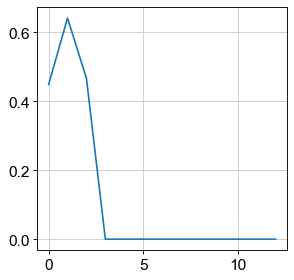

In [5]:
plot(adata.uns['schist']['stats']['modularity'])

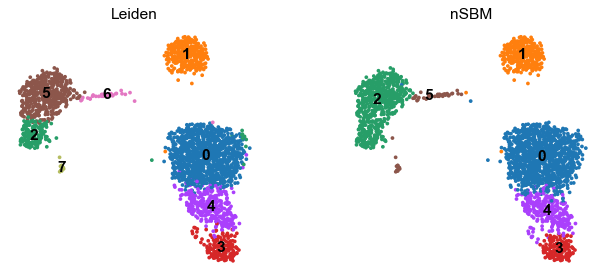

In [6]:
sc.pl.umap(adata, color=['leiden', 'nsbm_level_1'], legend_loc='on data', 
           frameon=False,  title=['Leiden', 'nSBM'], save='Original_PBMC3k.png')

In [7]:
import sklearn.metrics
sklearn.metrics.adjusted_rand_score(adata.obs.leiden, adata.obs.nsbm_level_1)

0.8699142596243707

In [217]:
sklearn.metrics.adjusted_rand_score(adata.obs.louvain, adata.obs.nsbm_level_1)

0.8944226721213248

In [218]:
sklearn.metrics.adjusted_rand_score(adata.obs.louvain, adata.obs.nsbm_level_0)

0.4422370738213311

In [219]:
sklearn.metrics.adjusted_rand_score(adata.obs.leiden, adata.obs.louvain)

0.9228248282460317

Here we extract the connectivities, which will be randomized

In [9]:
# extract kNN graph
conn = adata.obsp['connectivities'].todense()
dist = adata.obsp['distances'].todense()

# extract the edgelist

idx = np.nonzero(np.triu(conn,1))
weights = conn[idx].A1
dists = dist[idx].A1
e0 = idx[0].copy()
e1 = idx[1].copy()
#oe0 = idx[0].copy()
#oe1 = idx[1].copy()

# randomize the edgelist
np.random.shuffle(e1)
np.random.shuffle(e0)

# build a random kNN graph. In this way we conserve node degree
r_conn = np.zeros_like(conn)
r_dist = np.zeros_like(dist)

for x in range(len(e0)):
#    on0 = oe0[x]
#    on1 = oe1[x]
    n0 = e0[x]
    n1 = e1[x]
    r_conn[n0, n1] = weights[x]
    r_conn[n1, n0] = weights[x]
    r_dist[n0, n1] = dists[x]
    r_dist[n1, n0] = dists[x]


# plug the new data into an AnnData
rdata.obsp['connectivities'] = scipy.sparse.csr_matrix(r_conn)
rdata.obsp['distances'] = scipy.sparse.csr_matrix(r_dist)

# just some checks here
og = scs._utils.get_graph_tool_from_adjacency(adata.obsp['connectivities'], directed=False)
rg = scs._utils.get_graph_tool_from_adjacency(rdata.obsp['connectivities'], directed=False)

#print(og.num_vertices(), rg.num_vertices())

#print(og.num_edges(), rg.num_edges())

Check that the original kNN and the random have similar degree distribution. We do this using a Kolmogorov-Smirnoff test on the degree

In [10]:
on, od = gt.vertex_hist(og, 'total')
rn, rd = gt.vertex_hist(rg, 'total')
ks = scipy.stats.ks_2samp(rn, on)
print(f'D: {ks[0]}, p: {ks[1]}')

D: 0.0733032873806999, p: 0.7028526992719394


Also, fit and plot the degree distribution

In [11]:
of = powerlaw.Fit(on)
rf = powerlaw.Fit(rn)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


In [12]:
of.alpha, rf.alpha

(1.6640656709526693, 1.704133395286875)

<AxesSubplot:>

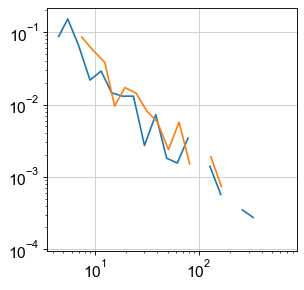

In [13]:
of.plot_pdf()# original_data=True)
rf.plot_pdf()# original_data=True)

Now we extract cell groups with default method (leiden, to optimize modularity) and nSBM

In [14]:
scs.inference.leiden(rdata)
scs.inference.nested_model(rdata)

running Leiden clustering
    finished (0:02:01)
minimizing the nested Stochastic Block Model
    done (0:02:46)
    finished (0:02:46)


Plot results on the precomputed UMAP

In [15]:
print(f'Leiden results in {len(rdata.obs["leiden"].cat.categories)} group(s)')
print(f'nSBM results in {len(rdata.obs["nsbm_level_0"].cat.categories)} group(s)')
                           

Leiden results in 24 group(s)
nSBM results in 1 group(s)


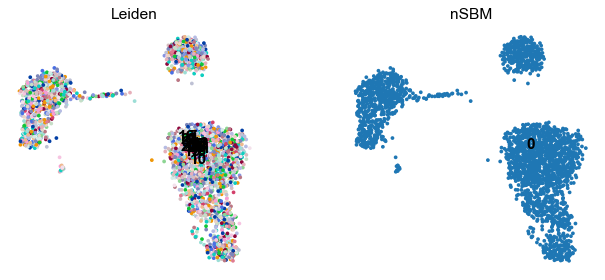

In [16]:
sc.pl.umap(rdata, color=['leiden', 'nsbm_level_0'], legend_loc='on data', 
           frameon=False, title=['Leiden', 'nSBM'], save='Random_PBMC3K.png')


Also, calculate a new UMAP and plot results on that. Note that UMAP embedding looks like a blob, reflecting the absence of information

computing UMAP
    finished (0:01:10)


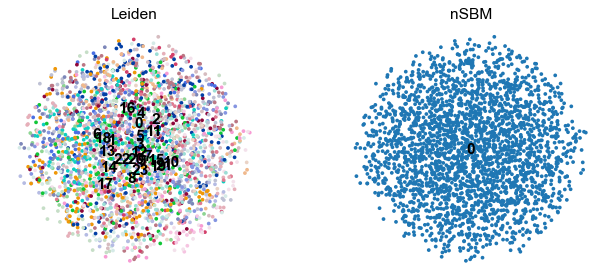

In [17]:
sc.tl.umap(rdata)
sc.pl.umap(rdata, color=['leiden', 'nsbm_level_0'], legend_loc='on data', 
           frameon=False, title=['Leiden', 'nSBM'], save='Random_PBMC3K_blob.png')



In [18]:
print(np.sum(adata.uns['schist']['stats']['level_entropy']), np.sum(rdata.uns['schist']['stats']['level_entropy']))

97385.67716421829 121129.56143641614


In [19]:
scs.io.write(adata, "PBMC_3k_074")
scs.io.write(rdata, "PBMC_3k_random_074")

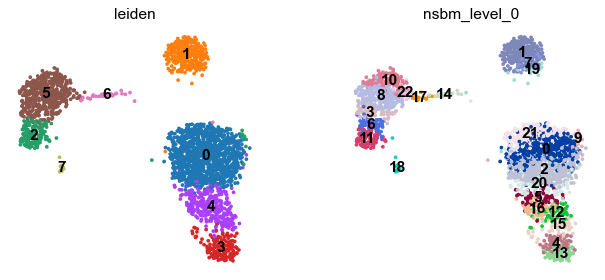

In [20]:
sc.pl.umap(adata, color=['leiden', 'nsbm_level_0'], legend_loc='on data',
          frameon=False)

In [4]:
adata = scs.io.read("PBMC_3k_074")
rdata = scs.io.read("PBMC_3k_random_074")

Add random noise to each gene, estimated from adata expression values

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:19)
computing UMAP
    finished (0:00:06)


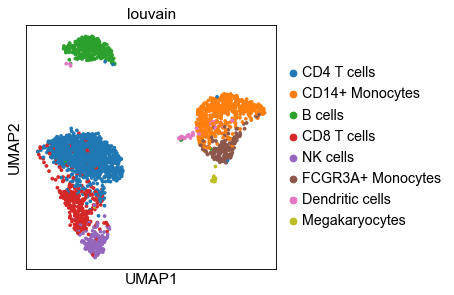

In [5]:
cdata = adata.copy()
cdata.X = adata.raw[:, adata.var_names].X
sc.tl.pca(cdata)
sc.pp.neighbors(cdata, n_neighbors=10)
sc.tl.umap(cdata)
sc.pl.umap(cdata, color='louvain')

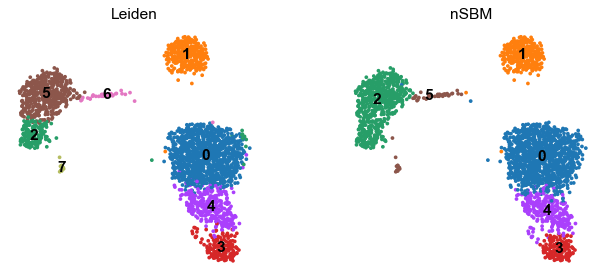

In [6]:
sc.pl.umap(adata, color=['leiden', 'nsbm_level_1'], legend_loc='on data', 
           frameon=False,  title=['Leiden', 'nSBM'], 
           save='Original_PBMC3k.pdf')

computing UMAP
    finished (0:00:05)


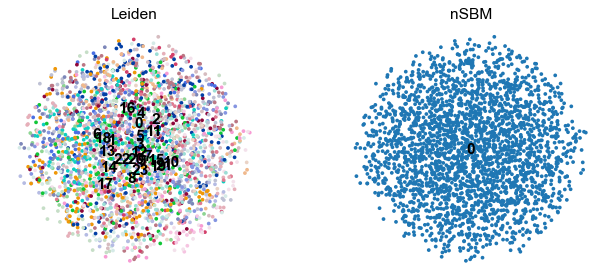

In [7]:
sc.tl.umap(rdata)
sc.pl.umap(rdata, color=['leiden', 'nsbm_level_0'], legend_loc='on data', 
           frameon=False, title=['Leiden', 'nSBM'], 
           save='Random_PBMC3K_blob.pdf')




In [58]:
ax = axs[0, 0]

In [ ]:
ax.text()

In [72]:
fig

<Figure size 320x320 with 0 Axes>

<Figure size 800x800 with 0 Axes>

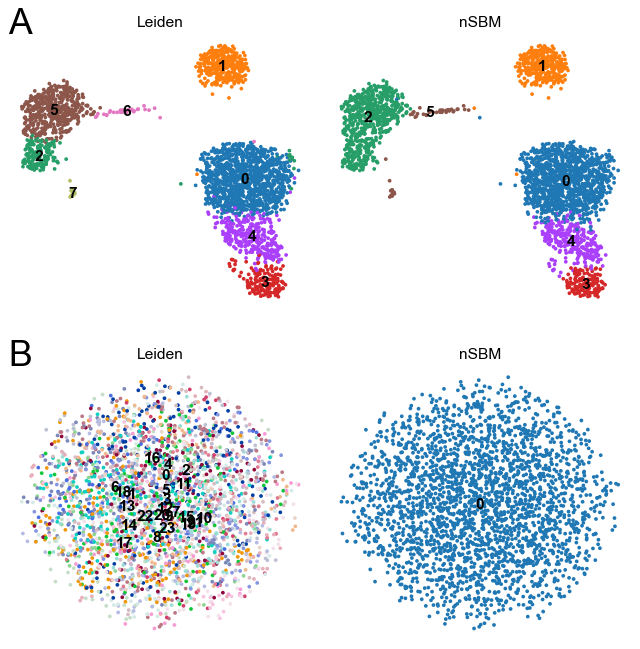

<Figure size 320x320 with 0 Axes>

In [79]:
fig = plt.figure(constrained_layout=False, figsize=(10, 10))
gs = fig.add_gridspec(nrows=2, ncols=2, wspace=0.05)

ax1=fig.add_subplot(gs[0, 0])
ax2=fig.add_subplot(gs[0, 1])
ax3=fig.add_subplot(gs[1, 0])
ax4=fig.add_subplot(gs[1, 1])



sc.pl.umap(adata, color=['leiden'], legend_loc='on data', 
           frameon=False,  title=['Leiden',], ax=ax1, show=False
           )
ax1.text(0, 1, 'A', size=32, transform=ax1.transAxes)


sc.pl.umap(adata, color=['nsbm_level_1'], legend_loc='on data', 
           frameon=False,  title=['nSBM',], ax=ax2, show=False
           )
sc.pl.umap(rdata, color=['leiden'], legend_loc='on data', 
           frameon=False, title=['Leiden'], ax=ax3, show=False)
ax3.text(0, 1, 'B', size=32, transform=ax3.transAxes)


sc.pl.umap(rdata, color=['nsbm_level_0'], legend_loc='on data', 
           frameon=False, title=['nSBM'], ax=ax4)

plt.tight_layout()
plt.show()

fig.savefig('Random_PBMC.pdf', dpi=300, transparent=True)

In [81]:
320/1600


0.2

In [167]:
ma_raw = np.ma.masked_equal(cdata.X.A, 0)

In [119]:
ma = np.ma.masked_array(adata.X, mask=ma_raw.mask)

In [168]:
gene_means = np.ma.mean(ma_raw, axis=0)
gene_stds = np.ma.std(ma_raw, axis=0)

In [201]:
rvs = np.array([np.random.normal(loc=gene_means.data[x], scale=1.5*gene_stds.data[x], size=adata.shape[0]) for x in range(adata.shape[1])])

rvs = rvs.T

gauss_data = cdata.copy()
gauss_data.X += rvs

In [204]:
sc.tl.pca(gauss_data)
sc.pp.neighbors(gauss_data, n_neighbors=10)

computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)


In [205]:
sc.tl.umap(gauss_data)

computing UMAP
    finished (0:00:08)


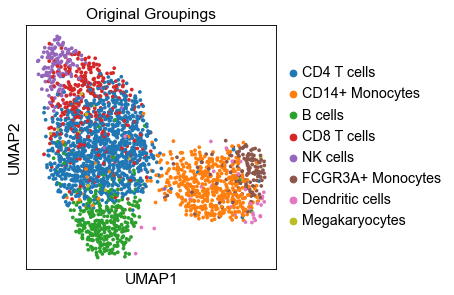

In [206]:
sc.pl.umap(gauss_data, color='louvain', title='Original Groupings')

In [207]:
scs.inference.leiden(gauss_data)
scs.inference.nested_model(gauss_data, n_jobs=4)

running Leiden clustering
    finished (0:00:50)
minimizing the nested Stochastic Block Model
        minimization step done (0:07:19)
        consensus step done (0:07:21)
    done (0:07:21)
    finished (0:07:21)


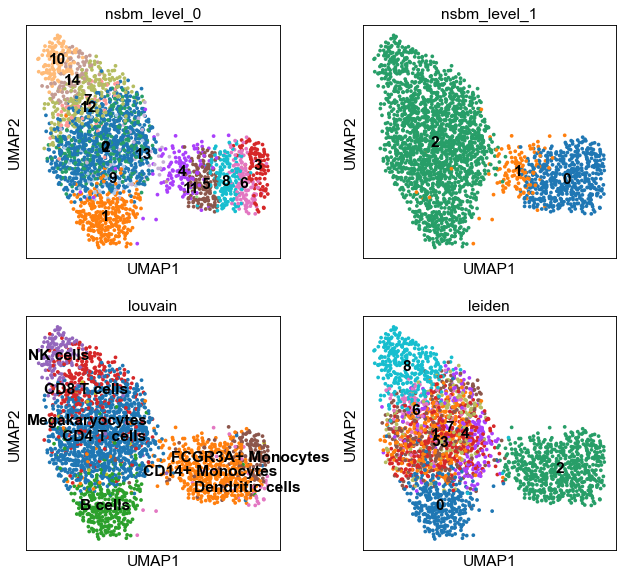

In [208]:
sc.pl.umap(gauss_data, color=['nsbm_level_0', 'nsbm_level_1', 'louvain','leiden'], 
           ncols=2, legend_loc='on data')

In [8]:
import sklearn.metrics


In [209]:
sklearn.metrics.adjusted_rand_score(gauss_data.obs.louvain, gauss_data.obs.leiden)

0.28327239053226466

In [210]:
sklearn.metrics.adjusted_rand_score(gauss_data.obs.louvain, gauss_data.obs.nsbm_level_1)

0.3108593903774264

In [211]:
sklearn.metrics.adjusted_rand_score(gauss_data.obs.louvain, gauss_data.obs.nsbm_level_0)

0.40745276511414497

In [212]:
sklearn.metrics.adjusted_rand_score(adata.obs.leiden, gauss_data.obs.leiden)

0.2904760154803508

In [213]:
sklearn.metrics.adjusted_rand_score(adata.obs.nsbm_level_1, gauss_data.obs.nsbm_level_1)

0.3350062413050154

In [214]:
sklearn.metrics.adjusted_rand_score(adata.obs.nsbm_level_0, gauss_data.obs.nsbm_level_0)

0.26544149199399414

In [216]:
scs.io.write(gauss_data, 'Gaussian_PBMC')

Test ARI at different levels of noise

In [229]:
gamma_mult = [0.5, 1, 1.5, 2]
ari_df = pd.DataFrame(0, columns=gamma_mult, index=['leiden', 'nsbm_level_0', 'nsbm_level_1'])
for m in gamma_mult:
    print(m)
    rvs = np.array([np.random.normal(loc=gene_means.data[x], scale=m*gene_stds.data[x], size=adata.shape[0]) for x in range(adata.shape[1])])
    rvs = rvs.T
    gauss_data = cdata.copy()
    gauss_data.X += rvs
    sc.tl.pca(gauss_data)
    sc.pp.neighbors(gauss_data, n_neighbors=10)
    scs.inference.leiden(gauss_data)
    scs.inference.nested_model(gauss_data, n_jobs=4)
    scs.io.write(gauss_data, f"GAUSS_{m}")
    for cl in ari_df.index:
        ari_df.loc[cl, m] = sklearn.metrics.adjusted_rand_score(gauss_data.obs.louvain, gauss_data.obs[cl])

0.5


computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
running Leiden clustering
    finished (0:00:29)
minimizing the nested Stochastic Block Model
        minimization step done (0:03:27)
        consensus step done (0:03:30)
    done (0:03:30)
    finished (0:03:30)


1


computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
running Leiden clustering
    finished (0:00:32)
minimizing the nested Stochastic Block Model
        minimization step done (0:04:54)
        consensus step done (0:04:56)
    done (0:04:56)
    finished (0:04:56)


1.5


computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
running Leiden clustering
    finished (0:00:31)
minimizing the nested Stochastic Block Model
        minimization step done (0:06:00)
        consensus step done (0:06:02)
    done (0:06:02)
    finished (0:06:03)


2


computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
running Leiden clustering
    finished (0:00:35)
minimizing the nested Stochastic Block Model
        minimization step done (0:05:25)
        consensus step done (0:05:28)
    done (0:05:28)
    finished (0:05:29)


In [230]:
ari_df

,0.5,1.0,1.5,2.0
leiden,0.624864,0.596560,0.283272,0.140494
nsbm_level_0,0.295826,0.378609,0.400882,0.132379
nsbm_level_1,0.750924,0.726956,0.302972,0.196083


In [11]:
scs.inference.nested_model(cdata)
scs.inference.leiden(cdata)

minimizing the nested Stochastic Block Model
        minimization step done (0:03:57)
        consensus step done (0:04:04)
    done (0:04:04)
    finished (0:04:04)
running Leiden clustering
    finished (0:00:35)


In [12]:
sklearn.metrics.adjusted_rand_score(cdata.obs['louvain'], cdata.obs['leiden'])

0.5524330302467657

In [13]:
sklearn.metrics.adjusted_rand_score(cdata.obs['louvain'], cdata.obs['nsbm_level_1'])

0.7586528675747687

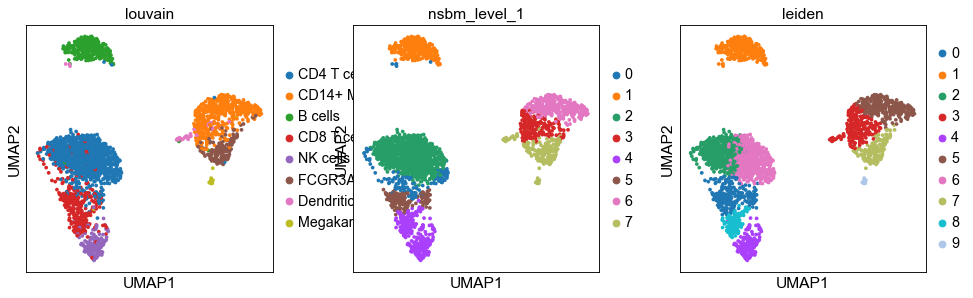

In [14]:
sc.pl.umap(cdata, color=['louvain', 'nsbm_level_1', 'leiden'])

In [231]:
ari_df.to_pickle("ARI_DF_Gauss.pickle")

In [19]:
len(adata.obs['leiden'].cat.categories)

8

In [20]:
len(adata.obs['nsbm_level_1'].cat.categories)

6

computing UMAP
    finished (0:00:05)


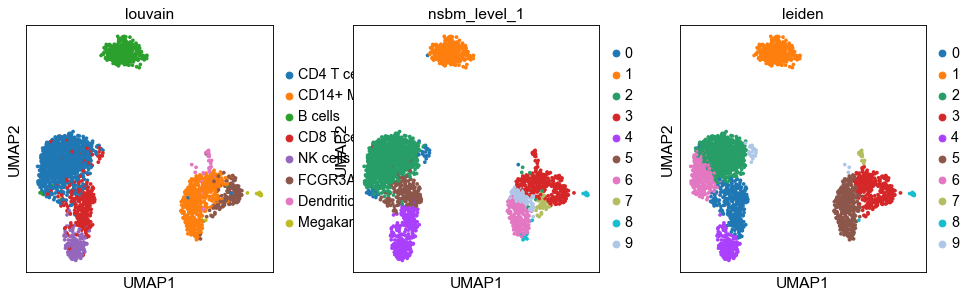

0.2665221792256224
0.7392080642528612
0.6279008896094899


computing UMAP
    finished (0:00:06)


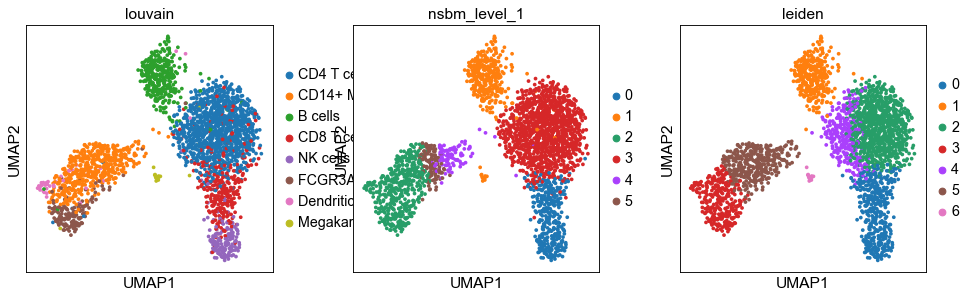

0.30605037764994864
0.7711614804116241
0.5941222264424896


computing UMAP
    finished (0:00:06)


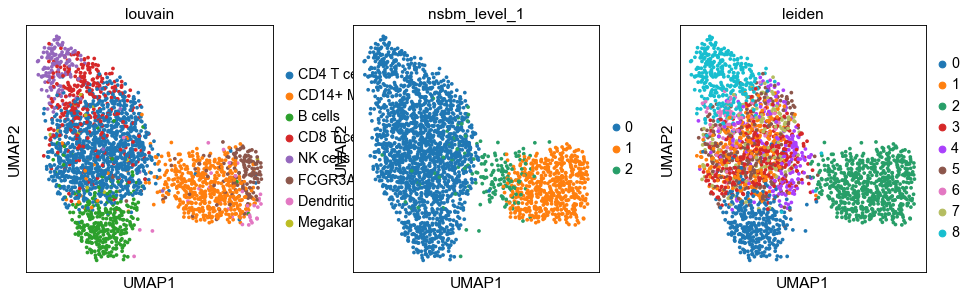

0.26483841478153547
0.3283474585922428
0.2904760154803508


computing UMAP
    finished (0:00:07)


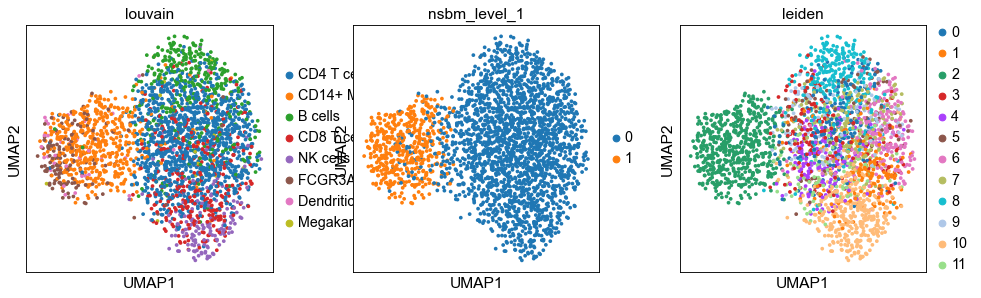

0.06843194002984501
0.20242203610226872
0.1449820793796518


In [235]:
for m in gamma_mult:
    gauss_data = scs.io.read(f"GAUSS_{m}")
    sc.tl.umap(gauss_data)
    sc.pl.umap(gauss_data, color=['louvain', 'nsbm_level_1', 'leiden'])
    print(sklearn.metrics.adjusted_rand_score(adata.obs['nsbm_level_0'], gauss_data.obs['nsbm_level_0']))
    print(sklearn.metrics.adjusted_rand_score(adata.obs['nsbm_level_1'], gauss_data.obs['nsbm_level_1']))
    print(sklearn.metrics.adjusted_rand_score(adata.obs['leiden'], gauss_data.obs['leiden']))    

Different resolutions for random graph

In [16]:
resolutions = np.arange(0.1, 1.1, 0.1)
n_clusters = np.zeros_like(resolutions)
for ng, gamma in enumerate(resolutions):
    scs.inference.leiden(rdata, resolution=gamma, key_added=f'leiden_{gamma}')
    nc = len(rdata.obs[f'leiden_{gamma}'].cat.categories)
    print(f'resolution: {gamma}; n_clusters: {nc}')
    n_clusters[ng] = nc

running Leiden clustering
    finished (0:00:27)
running Leiden clustering


resolution: 0.1; n_clusters: 1


    finished (0:00:33)
running Leiden clustering


resolution: 0.2; n_clusters: 1


    finished (0:00:30)
running Leiden clustering


resolution: 0.30000000000000004; n_clusters: 1


    finished (0:00:26)
running Leiden clustering


resolution: 0.4; n_clusters: 1


    finished (0:00:26)
running Leiden clustering


resolution: 0.5; n_clusters: 1


    finished (0:00:40)
running Leiden clustering


resolution: 0.6; n_clusters: 3


    finished (0:00:57)
running Leiden clustering


resolution: 0.7000000000000001; n_clusters: 6


    finished (0:01:07)
running Leiden clustering


resolution: 0.8; n_clusters: 12


    finished (0:01:02)
running Leiden clustering


resolution: 0.9; n_clusters: 18


    finished (0:01:22)


resolution: 1.0; n_clusters: 24


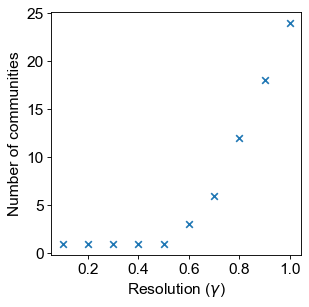

In [17]:
scatter(resolutions, n_clusters, marker='x')
grid()
xlabel(r"Resolution ($\gamma$)")
ylabel("Number of communities")
savefig("Random_Leiden_by_gamma.pdf", dpi=300)

In [18]:
scs.io.write(rdata, "PBMC_3k_random_074")

Shuffle genes in a subset of cells

In [41]:
shuf_data = adata.copy()

In [38]:
cell_idx = np.arange(adata.shape[0])
np.random.shuffle(cell_idx)

In [40]:
to_shuffle = cell_idx[:500]

In [42]:
gene_idx = np.arange(adata.shape[1])
for cell in to_shuffle:
    np.random.shuffle(gene_idx)
    shuf_data.X[cell] = shuf_data.X[cell][gene_idx]

In [43]:
sc.tl.pca(shuf_data)

computing PCA
    with n_comps=50
    finished (0:00:01)


In [44]:
sc.pp.neighbors(shuf_data, n_neighbors=10)
sc.tl.umap(shuf_data)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing UMAP
    finished (0:00:05)


In [45]:
shuf_data.obs['shuffled'] = False

In [47]:
shuf_data.obs['shuffled'][to_shuffle] =True

In [50]:
import pandas as pd

In [51]:
shuf_data.obs['shuffled'] = pd.Categorical(shuf_data.obs['shuffled'].astype(str))

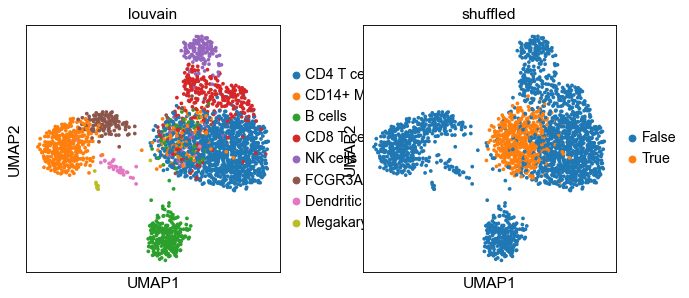

In [52]:
sc.pl.umap(shuf_data,color=['louvain', 'shuffled'])

In [55]:
scs.inference.leiden(shuf_data)
scs.inference.nested_model(shuf_data, n_jobs=2)

running Leiden clustering
    finished (0:00:30)
minimizing the nested Stochastic Block Model
        minimization step done (0:05:29)
        consensus step done (0:05:31)
    done (0:05:31)
    finished (0:05:31)


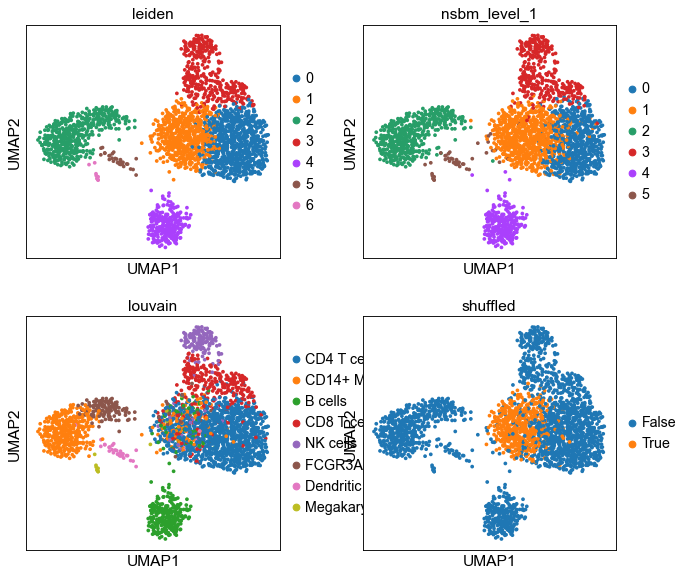

In [56]:
sc.pl.umap(shuf_data, 
           color=['leiden', 'nsbm_level_1', 'louvain', 'shuffled'], ncols=2)

In [57]:
pd.crosstab(shuf_data.obs['shuffled'], shuf_data.obs['leiden'])

leiden,0,1,2,3,4,5,6
shuffled,,,,,,,
False,803,159,505,352,279,30,10
True,27,461,0,12,0,0,0


In [58]:
pd.crosstab(shuf_data.obs['shuffled'], shuf_data.obs['nsbm_level_1'])

nsbm_level_1,0,1,2,3,4,5
shuffled,,,,,,
False,676,294,509,336,283,40
True,2,484,0,9,0,5


In [59]:
pd.crosstab(shuf_data.obs['shuffled'], shuf_data.obs['nsbm_level_0'])

nsbm_level_0,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
shuffled,,,,,,,,,,,,,,,,,,,,,
False,75,261,89,62,109,33,73,254,166,157,...,38,57,58,44,25,52,13,10,5,16
True,0,201,1,0,0,283,0,0,0,0,...,0,0,0,9,0,0,0,0,5,0


In [60]:
scs.io.write(shuf_data, 'Shuffled_PBMC')

In [62]:
sklearn.metrics.adjusted_rand_score(shuf_data.obs['louvain'], shuf_data.obs['leiden'])

0.5131125765528383

In [63]:
sklearn.metrics.adjusted_rand_score(shuf_data.obs['louvain'], shuf_data.obs['nsbm_level_1'])

0.44910948559507424